# *Контест 1*
# *Линейная регрессия*
# *Потапов Егор, м8о-309б-22*

*Подключение необходимых библиотек*

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score

*Загружаем датасет и проверяем загрузку*

In [5]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


*Берём переменную, которую будем предсказывать*

In [6]:
y = df_train['RiskScore']

## Количество данных

In [7]:
print(df_train.shape)
print(df_test.shape)

(11017, 36)
(5000, 36)


*Описание предсказываемой переменной*

In [8]:
df_train[['RiskScore']].describe(percentiles=[0.01, 0.03, 0.1, 0.5, 0.75, 0.90, 0.97, 0.99])

,RiskScore
count,1.048700e+04
mean,-2.569878e+04
std,1.431675e+06
min,-9.999999e+06
1%,-9.999999e+06
3%,2.432579e+01
10%,2.831219e+01
50%,4.411876e+01
75%,6.535690e+01
90%,7.259076e+01


*Пропуски в данных, причем у train их очень много*

In [9]:
df_test.isna().sum()

ID                            0
ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInte

In [10]:
df_train.isna().sum()

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

*Группы значений каждого признака*

In [11]:
category_features = df_train.select_dtypes(object).columns
category_features

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')

In [12]:
for feature in category_features:
  print(df_train[feature].value_counts(), end='\n-----\n-----\n')

ApplicationDate
1996-04-03    3
1997-08-06    3
1983-01-31    3
1986-05-04    3
1995-04-25    3
             ..
1998-06-15    1
2000-06-26    1
1983-08-19    1
2019-09-25    1
2001-12-28    1
Name: count, Length: 10000, dtype: int64
-----
-----
MaritalStatus
Married     5145
Single      3217
Divorced    1562
Widowed      563
Name: count, dtype: int64
-----
-----
HomeOwnershipStatus
Mortgage    4148
Rent        3186
Own         2116
Other       1037
Name: count, dtype: int64
-----
-----
LoanPurpose
Home                  2981
Debt Consolidation    2446
Auto                  2010
Education             1601
Other                  948
Name: count, dtype: int64
-----
-----
EmploymentStatus
Employed         9059
Self-Employed     992
Unemployed        436
Name: count, dtype: int64
-----
-----
EducationLevel
High School    4234
Bachelor       3092
Associate      2057
Master          755
Doctorate       349
Name: count, dtype: int64
-----
-----


# Кодируем категор. признаки
Удаляем строки с пропущенными значениями в категориальных признаках, а так же заполняем пропущенные значения

In [13]:
df_train = df_train.dropna(subset=category_features.drop(['EmploymentStatus']), axis=0)
df_test = df_test.dropna(subset=category_features.drop(['EmploymentStatus']), axis=0)

df_train = df_train.dropna(subset=['Experience'], axis=0)
df_test = df_test.dropna(subset=['Experience'], axis=0)


y = df_train['RiskScore']

In [14]:
df_train['EmploymentStatus'] = df_train['EmploymentStatus'].fillna(value='Employed')

In [15]:
df_train.isna().sum()

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
Interest

*Кодируем категориальные признаки, которые лучше воспринимаются нашей моделью*

In [16]:
def mean_target_encode(df, features: list[str], df_test):
  enc = TargetEncoder()
  for feature in features:
    enc = enc.fit(df[feature].values.reshape(-1, 1), y.values)
    df[feature] = enc.transform(df[feature].values.reshape(-1, 1))
    df_test[feature] = enc.transform(df_test[feature].values.reshape(-1, 1))


mean_target_encoded_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
mean_target_encode(df_train, mean_target_encoded_features, df_test)
df_train

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,-40162.315572,1.0,-32987.689127,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,-56180.985813,1.0,-32788.988379,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,-28454.639853,0.0,-32788.988379,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,-28454.639853,0.0,20350.571111,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,-26191.817952,2.0,-32987.689127,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11010,1984-09-26,47.0,88686.0,648.0,5472.0,12.0,-40162.315572,2.0,-32987.689127,98.0,...,Employed,Bachelor,23.0,121698.0,0.156472,0.164928,497.756143,0.080611,1.0,41.553066
11011,1980-01-15,39.0,300000.0,850.0,7721.0,72.0,-40162.315572,5.0,-49523.589815,276.0,...,Employed,Associate,16.0,18607.0,0.107721,0.108596,146.407421,0.016896,1.0,28.051757
11012,2010-07-10,57.0,300000.0,850.0,14756.0,48.0,-28454.639853,2.0,-49523.589815,620.0,...,Employed,Associate,38.0,167544.0,0.094756,0.106387,378.792448,0.039952,1.0,32.440586
11013,2003-10-22,28.0,15000.0,300.0,51361.0,96.0,-26191.817952,1.0,-49523.589815,696.0,...,Employed,Bachelor,5.0,116879.0,0.446361,0.401087,1793.042130,1.991234,0.0,67.673170


*Так же преобразует категориальные признаки в числовые значения, чтобы с ними могла работать модель*

In [17]:
def label_encode(df, features: list[str], df_test):
  le = LabelEncoder()
  for feature in features:
    le = le.fit(df[feature].values)
    df[feature] = le.transform(df[feature])
    df_test[feature] = le.transform(df_test[feature])

label_encoded_features =  ['EducationLevel', 'EmploymentStatus']
label_encode(df_train, label_encoded_features, df_test)

*Удаляем выбросы, они нам не нужны и будут только мешать*

In [18]:
df_train = df_train[df_train['RiskScore'] > df_train['RiskScore'].quantile(q=0.01)]
df_train = df_train[df_train['RiskScore'] < df_train['RiskScore'].quantile(q=0.99)]
y = df_train['RiskScore']

## Визуализация данных


### Гистограмма распределения переменной RiskScore + график плотности ядра

*Здесь мы можем наблюдать два основых пика: один около 30 и другой около 70, что указывает на существование двух групп наблюдений с различными уровнями риска*

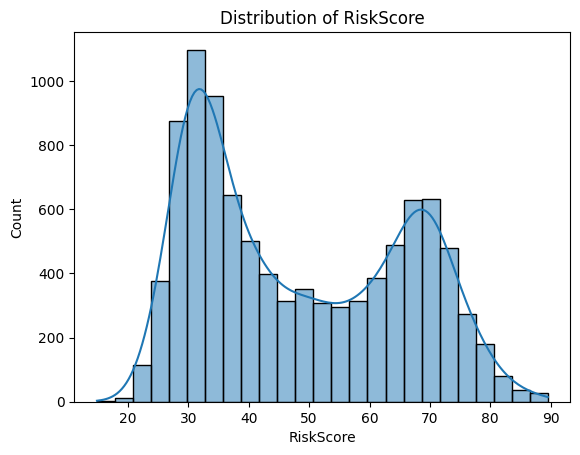

In [19]:
sns.histplot(df_train['RiskScore'], kde=True)
plt.title('Distribution of RiskScore')
plt.show()

*Так же интересно посмотреть на RiskSkore по занятости*

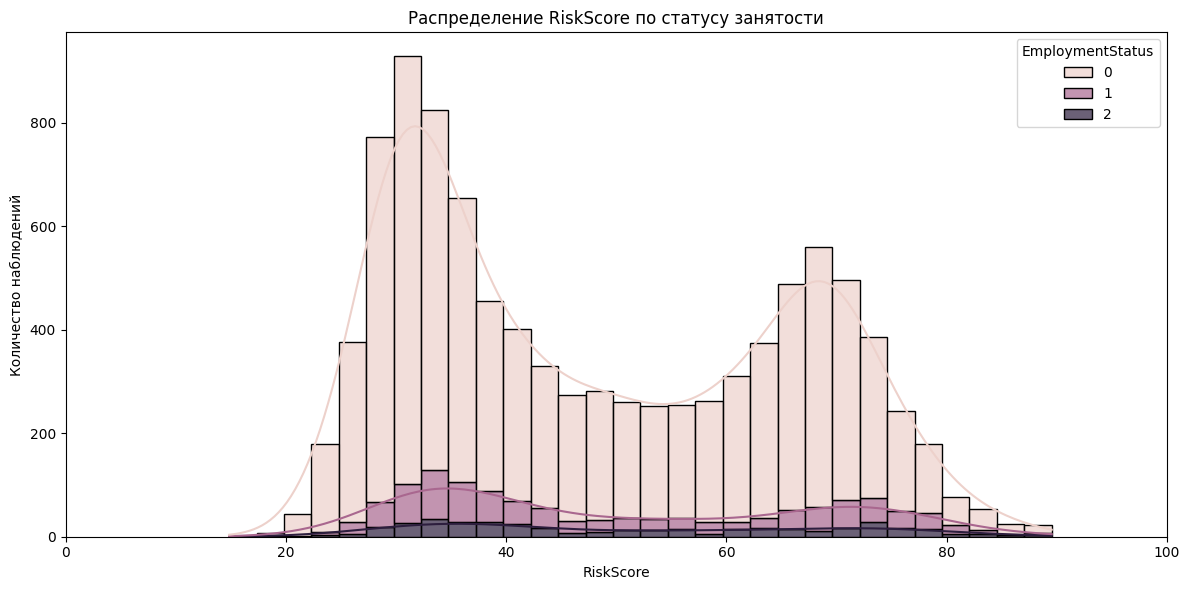

In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='RiskScore', hue='EmploymentStatus', bins=30, kde=True, alpha=0.7, multiple='stack')
plt.title('Распределение RiskScore по статусу занятости')
plt.xlabel('RiskScore')
plt.ylabel('Количество наблюдений')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

*Удаляю целевую переменную из выборки*

In [34]:
df_train.drop(['ApplicationDate', 'RiskScore'], axis=1, inplace=True)
test_id = df_test['ID']
df_test.drop(['ApplicationDate', 'ID'], axis=1, inplace=True)

*Пайплайн для предварительной обработки данных и обучения модели линейной регрессии*

In [35]:
pipeline = make_pipeline(StandardScaler(), linear_model.LinearRegression())

In [37]:
pipeline.fit(df_train, y)
y_pred = pipeline.predict(df_test)
y_train_pred = pipeline.predict(df_train)
print("MSE: ", mean_squared_error(y_train_pred, y))

with open('submission.csv', 'w') as file:
  file.write("ID,RiskScore\n")
  for id, pred in zip(test_id, y_pred):
    file.write(f"{id},{pred}\n")

MSE:  19.026560408578412
